In [17]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

In [18]:
import pandas as pd

# Define the file path using a raw string literal
file_path = r'C:\Users\Admin\Downloads\data.parquet'

# Load the Parquet file into a DataFrame
data = pd.read_parquet(file_path)

data = data.between_time('09:15', '15:30').copy()
print(data.head(2000))

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27
...                        ...       ...  ...
2021-01-06 11:10:00   0.260242  0.185839   22
2021-01-06 11:11:00   0.260502  0.185785   22
2021-01-06 11:12:00   0.260182  0.185409   22
2021-01-06 11:13:00   0.260344  0.182506   22
2021-01-06 11:14:00   0.261583  0.182521   22

[2000 rows x 3 columns]


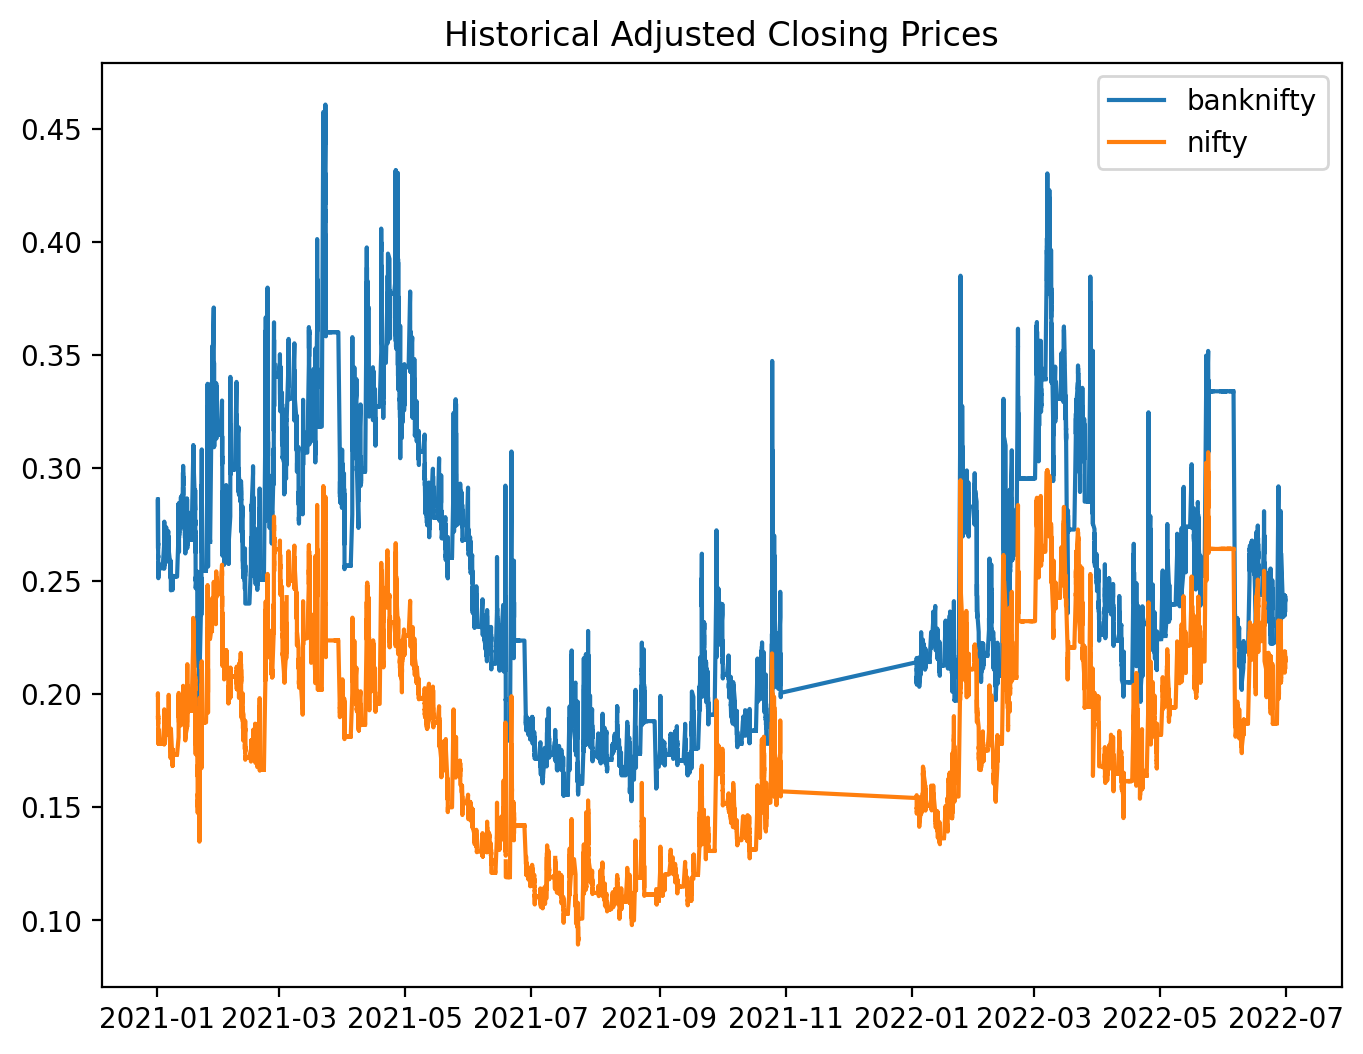

In [19]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=200)
plt.plot(data["banknifty"], label="banknifty")
plt.plot(data["nifty"], label="nifty")
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show()


In [20]:
data.isnull().sum()

banknifty    370
nifty        477
tte            0
dtype: int64

In [21]:
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
# Introduce `IterativeImputer()`
imp = IterativeImputer()
# Fit to your manipulated df
imp.fit(data)
# Transform and save the transformed data as a dataframe
data_filled = pd.DataFrame(imp.transform(data), columns = data.columns, index = data.index)
data_filled.isnull().sum()

banknifty    0
nifty        0
tte          0
dtype: int64

<Axes: >

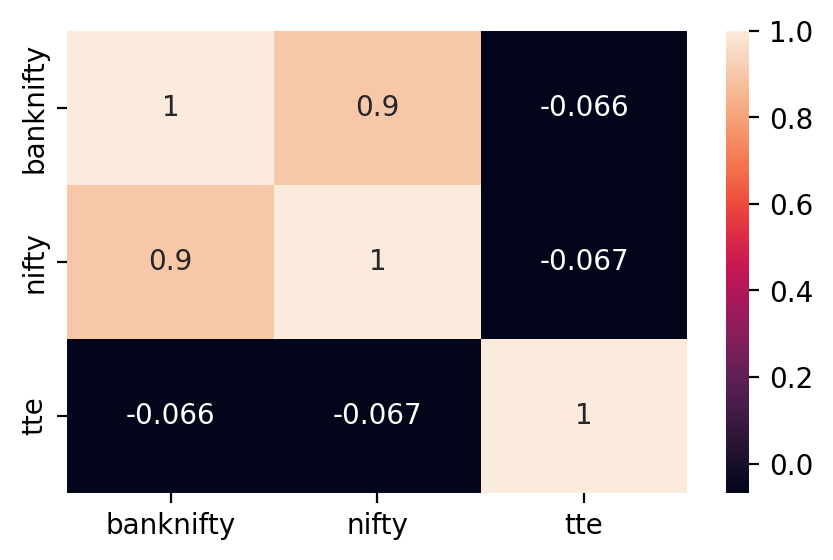

In [22]:
corr_matrix = data.corr()
corr_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 3), dpi=200)
sns.heatmap(corr_matrix, annot = True)

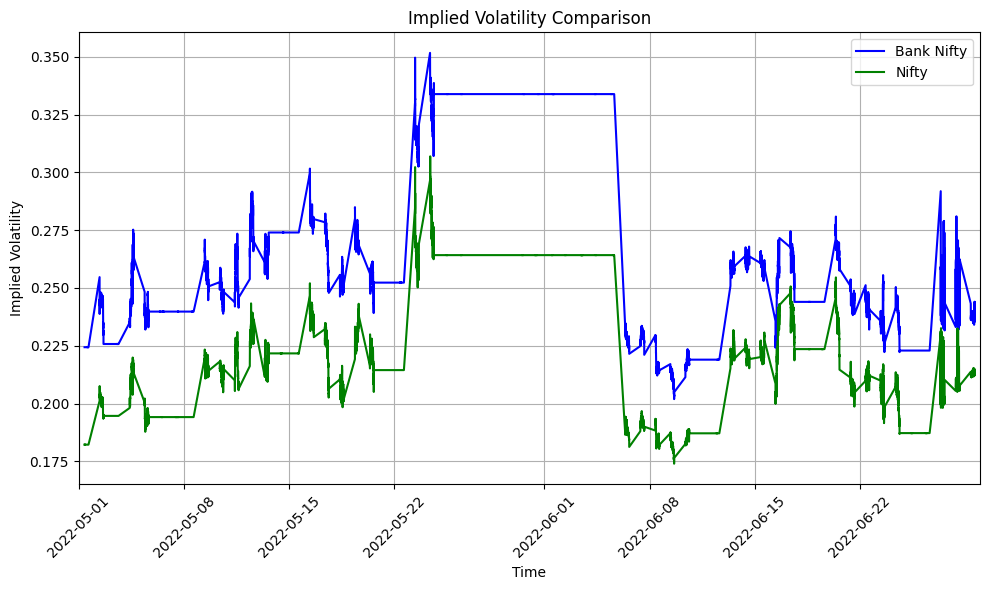

In [23]:

# Assume 'time' is not present, instead, we'll use the index as time
data.index = pd.to_datetime(data.index)  # Convert index to datetime if it's not already

# Specify the start and end dates for the duration you want to plot
start_date = pd.to_datetime('2022-05-01')  # Convert start date to datetime object
end_date = pd.to_datetime('2022-06-30')  # Convert end date to datetime object

# Filter the data for the specified duration
data_subset = data.loc[start_date:end_date]

# Plot the line chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot Bank Nifty implied volatility
plt.plot(data_subset.index, data_subset['banknifty'], label='Bank Nifty', color='blue', linestyle='-')

# Plot Nifty implied volatility
plt.plot(data_subset.index, data_subset['nifty'], label='Nifty', color='green', linestyle='-')

plt.title('Implied Volatility Comparison')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.legend()  # Show legend

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.xlim(start_date, end_date)

plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()


In [28]:
_, pvalue, _ = coint(data_filled['banknifty'],data_filled['nifty'])

if pvalue <0.05:
    print("The time series are cointegrated.", pvalue)
else:
    print("The time series are not cointegrated.")



KeyboardInterrupt



We use the cointegration test for the trading model of z-score of the spread
Cointegration test: A technique used to find a potential correlation in a time series (long term) Determines if the spread between the two assets are constant over time
# Null Hypothesis: Spread between series are non-stationary
# Uses the augmented Engle-Granger two-step cointegration tet.


In [29]:
from scipy.stats import zscore

data_filled['spread'] = data_filled['banknifty'] - data_filled['nifty']
data_filled['z_score'] = zscore(data_filled['spread'])

data_filled.head()

,banknifty,nifty,tte,spread,z_score,P/L
time,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0,0.086329,0.544640,0.867184
2021-01-01 09:16:00,0.285381,0.200433,27.0,0.084948,0.492540,0.853317
2021-01-01 09:17:00,0.284233,0.200004,27.0,0.084229,0.465385,0.846089
2021-01-01 09:18:00,0.286104,0.199860,27.0,0.086244,0.541413,0.866325
2021-01-01 09:19:00,0.285539,0.198951,27.0,0.086588,0.554415,0.869786


In [30]:
data_filled['P/L'] = data_filled['spread'] * data_filled['tte'] ** 0.7


In [42]:
df= data_filled.copy()
df.head()

,banknifty,nifty,tte,spread,z_score,P/L
time,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0,0.086329,0.544640,0.867184
2021-01-01 09:16:00,0.285381,0.200433,27.0,0.084948,0.492540,0.853317
2021-01-01 09:17:00,0.284233,0.200004,27.0,0.084229,0.465385,0.846089
2021-01-01 09:18:00,0.286104,0.199860,27.0,0.086244,0.541413,0.866325
2021-01-01 09:19:00,0.285539,0.198951,27.0,0.086588,0.554415,0.869786


In [43]:

# arbitrary thresholds for trading signals
long_threshold = -1.0
short_threshold = 1.0

# Initialize variables for tracking trades
in_trade = False
trade_type = None
entry_price = 0
entry_index = 0
exit_index = 0
pnl = 0

# Iterate through the data
for i in range(len(df)):
    # Check if we are in a trade and if it's time to exit
    if in_trade and (i - entry_index) >= 1875:
        pnl += (df.iloc[i]['P/L'] - entry_price) if trade_type == 'long' else (entry_price - df.iloc[i]['P/L'])
        in_trade = False
        exit_index = i
    
    # Check for entry signals
    if not in_trade:
        if df.iloc[i]['z_score'] < long_threshold:
            in_trade = True
            trade_type = 'long'
            entry_price = df.iloc[i]['P/L']
            entry_index = i
        elif df.iloc[i]['z_score'] > short_threshold:
            in_trade = True
            trade_type = 'short'
            entry_price = df.iloc[i]['P/L']
            entry_index = i

# Calculate final P/L if trade is still open
if in_trade:
    pnl += (df.iloc[exit_index]['P/L'] - entry_price) if trade_type == 'long' else (entry_price - df.iloc[exit_index]['P/L'])

print("Total P/L:", pnl)


Total P/L: 5.674162849221504


In [54]:
# Calculate cumulative P/L
df['cumulative_pnl'] = df['P/L'].cumsum()


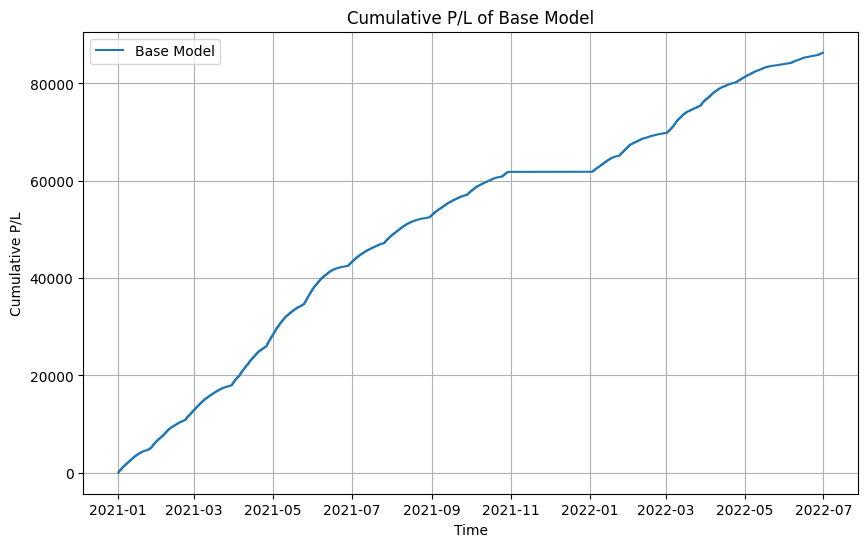

In [55]:
# Plot cumulative P/L of the base model
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['cumulative_pnl'], label='Base Model')
plt.title('Cumulative P/L of Base Model')
plt.xlabel('Time')
plt.ylabel('Cumulative P/L')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
# Calculate statistics of the base model
sharpe_ratio_base = df['P/L'].mean()-0.07 / df['P/L'].std() 
max_drawdown_base = (df['cumulative_pnl'].cummax() - data['cumulative_pnl']).max()
absolute_pnl_base = df['cumulative_pnl'].iloc[-1]

print('Base Model Statistics:')
print(f'Sharpe Ratio: {sharpe_ratio_base}')
print(f'Max Drawdown: {max_drawdown_base}')
print(f'Absolute P/L: {absolute_pnl_base}')

Base Model Statistics:
Sharpe Ratio: 0.2240202392160343
Max Drawdown: 0.07677310948929517
Absolute P/L: 86323.24970698253


We have created the Base model using Z-score of spread. Now to optimise it, we can use the ARIMA (autoregressive integrated moving average) to foreacst the spread value, using which we can either long Nifty and short Banknifty or vice-versa

In [57]:
df2 = data_filled.copy()

In [59]:
trading_signals = []
for i in range(len(forecast)):
    if forecast[i] > 0:
        trading_signals.append('buy')  # Buy signal
    else:
        trading_signals.append('sell')  # Sell signal


KeyError: 0

In [ ]:
# Calculate P/L based on trading signals
initial_capital = 1000000  # Initial capital in base currency (e.g., USD)
df2 = pd.DataFrame(index=data.index[-forecast_steps:], columns=['P/L'])
capital = initial_capital
for i, signal in enumerate(trading_signals):
    if signal == 'buy':
        df2.iloc[i]['P/L'] = data['spread'].iloc[-forecast_steps + i]  # Assuming buying at the current spread value
        capital -= data['spread'].iloc[-forecast_steps + i]  # Deducting buying cost from capital
    else:
        df2.iloc[i]['P/L'] = -data['spread'].iloc[-forecast_steps + i]  # Assuming selling at the current spread value
        capital += data['spread'].iloc[-forecast_steps + i]  # Adding selling proceeds to capital

# Calculate total P/L
total_pnl = df2['P/L'].sum()

print("Total P/L:", total_pnl)